# Expected Completion

### Conor Malone 14/05/2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #plot AUC
from scipy.spatial.distance import cdist #function to get distances
import xgboost as xgb #gradient boosted decision tree classification method
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, classification_report, mean_squared_error, log_loss,confusion_matrix, roc_curve, auc #metrics to assess model

In [2]:
plays = pd.read_csv("data/pass_receiver.csv")
pff = pd.read_csv("data/pffScoutingData.csv")
games = pd.read_csv("data/games.csv")

read in weekly tracking files and concatenate into one tracking file, then delete weeklies

In [3]:
week1 = pd.read_csv("data/week1.csv")
week2 = pd.read_csv("data/week2.csv")
week3 = pd.read_csv("data/week3.csv")
week4 = pd.read_csv("data/week4.csv")
week5 = pd.read_csv("data/week5.csv")
week6 = pd.read_csv("data/week6.csv")
week7 = pd.read_csv("data/week7.csv")
week8 = pd.read_csv("data/week8.csv")
tracking = pd.concat([week1,week2,week3,week4,week5,week6,week7,week8])


In [4]:
#save memory
del week1,week2,week3,week4,week5,week6,week7,week8

In [5]:
plays = plays.merge(games[["gameId","homeTeamAbbr"]], on = "gameId")
plays["possTeamScoreDiff"] = np.where(plays["homeTeamAbbr"]==plays["possessionTeam"],plays["preSnapHomeScore"]-plays["preSnapVisitorScore"],plays["preSnapVisitorScore"]-plays["preSnapHomeScore"])
plays["possTeamInLead"] = np.where(plays["possTeamScoreDiff"]>0,1,0)

add unique identifier of each play and frame (some playIds repeat over games)

In [6]:
tracking["comb_id"] = tracking["gameId"].astype("str")+" "+tracking["playId"].astype("str")
pff["comb_id"] = pff["gameId"].astype("str")+" "+pff["playId"].astype("str")
plays["comb_id"] = plays["gameId"].astype("str")+" "+plays["playId"].astype("str")
tracking["comb_and_frame"] = tracking["gameId"].astype("str")+" "+tracking["playId"].astype("str")+" "+tracking["frameId"].astype("str")

isolate frames at time of pass

In [7]:
#isolate just forward passes and leave out a certain frame (duplicate forward pass for a play)
just_forward_passes = tracking[(tracking["event"]=="pass_forward") & (tracking["comb_and_frame"]!="2021091203 3740 32")& (tracking["team"]!="football")]
#bring in receiver info from plays
tracking_plays =just_forward_passes.merge(plays[["comb_id","possessionTeam","is_pass_failed","PassReceiver_nflId","down","yardsToGo","yardlineNumber","possTeamScoreDiff","possTeamInLead"]], how="left",on="comb_id" )
#and qb info from pff
tracking_merged_all = tracking_plays.merge(pff[["comb_id","nflId","pff_role"]], how = "left",on=["comb_id","nflId"])

# Function to take in 1 pass play and  format it

In [8]:
def one_play_function(data):
    one_play_formatted_list = pd.DataFrame()
    data = data.reset_index(drop=True)
    comb_id = data["comb_id"][0]
    #get y, the response variable for this play (binary pass completed or not) and possesionteam (for CV)
    y = data["is_pass_failed"][0]
    team = data["possessionTeam"][0]
    QB = data[data["pff_role"]=="Pass"].head(1)
    WR = data[data["nflId"]==data["PassReceiver_nflId"]]
    #if no clear receiver just pick anyone
    if len(WR)==0:
        WR = data[data["pff_role"]=="Pass Route"].head(1)
 
    qb_loc = QB[["x","y"]]
    wr_loc = WR[["x","y"]]
    coverage_loc = data[["x","y"]][data["pff_role"]=="Coverage"]
    rush_loc = data[["x","y"]][data["pff_role"]=="Pass Rush"]
    #put play in adjacency matrix format, the distance of all players to each other (this will then be filtered to just link relevant players to QB or WR)
    QB_dist = min((i for i in cdist(qb_loc.values,wr_loc.values)[0] if i is not None),default=[])
    Coverage_dist = min((i for i in cdist(coverage_loc.values,wr_loc.values)[0] if i is not None),default=[])
    if len(rush_loc)==0:
        Rush_dist = None
    else:
        Rush_dist = min((i for i in cdist(rush_loc.values,qb_loc.values)[0] if i is not None),default=[])#min((i for i in cdist(rush_loc.values,qb_loc.values)[0] if i is not None),default=[])
    #then put play in features format, getting a table containing position, speed, orientation etc
    rel_o = WR["o"].iloc[0]-QB["o"].iloc[0]
    rel_dir = WR["dir"].iloc[0]-QB["dir"].iloc[0]
    wr_s = WR["s"]
    qb_s = QB["s"]
    one_play = pd.DataFrame({"comb_id":comb_id,"y":y,"Team":team,"QB_Dist":QB_dist,"DB_Dist":Coverage_dist,"Rush_Dist":Rush_dist,"Orientation":rel_o,"Direction":rel_dir,"WR_Speed":WR["s"],"QB_Speed":QB["s"],"down":WR["down"],"yardsToGo":WR["yardsToGo"],"yardLine":WR["yardlineNumber"],"ScoreDiff":WR["possTeamScoreDiff"],"inLead":WR["possTeamInLead"]})
    
    
    one_play_formatted_list = pd.concat([one_play_formatted_list,one_play], ignore_index = True)
    return one_play_formatted_list

run function on each play in dataset

In [9]:
table_list = pd.DataFrame()
for i in range(len(tracking_merged_all.comb_id.unique())):    
    one_play = tracking_merged_all[tracking_merged_all.comb_id==tracking_merged_all.comb_id.unique()[i]]
    one_play = one_play.reset_index(drop=True)
    result = one_play_function(one_play)
    table_list = pd.concat([table_list,result],ignore_index=True)


workaround to stop adding duplicate cols when qb_speed is included

In [10]:

qb_speed = table_list[["comb_id","QB_Speed"]][~table_list.QB_Speed.isna()]
tab_2 = table_list[table_list.QB_Speed.isna()].drop("QB_Speed", axis=1)
tab_2 = tab_2.merge(qb_speed, on = "comb_id")
table_list = tab_2

Cross Validation with k = 32 by loop through and for each team use as val (remove from training) and store predictions

In [56]:
# Define the XGBoost model
model = xgb.XGBClassifier()
unique_team_list = table_list.Team.unique()
prediction_list = []
#cross validate leaving out each team once
#for i in range(len(unique_team_list)):
for i in range(5):
    train = table_list[table_list["Team"]!=unique_team_list[i]]
    val = table_list[table_list["Team"]==unique_team_list[i]]
    x_train = np.array(train.loc[:, "QB_Dist":"QB_Speed"])
    y_train = np.array(train.loc[:,"y"])
    model.fit(x_train, y_train)
    predictions = model.predict(np.array(table_list.loc[:, "QB_Dist":"QB_Speed"]))
    prediction_list.append(predictions)

get average prediction for each play from the 32 runs

In [57]:
model_output2 = np.mean(prediction_list, axis=0)

In [58]:
len(model_output2)

7558

In [59]:
table_list2 = table_list.copy()
table_list2["pred"] = model_output2.tolist()

y_test = table_list2["y"]
y_pred = np.where(table_list2["pred"]>.5,1,0)

In [60]:
mean_squared_error(y_test, y_pred)

0.054644085736967454

In [61]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')

In [62]:
print(accuracy)

0.9453559142630326


In [63]:
print(precision)

0.982830980541778


In [64]:
print(recall)

0.875


In [65]:
print(f1)

0.9257861635220126


In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4614
           1       0.98      0.88      0.93      2944

    accuracy                           0.95      7558
   macro avg       0.95      0.93      0.94      7558
weighted avg       0.95      0.95      0.94      7558



In [67]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
auc(fpr, tpr)

0.9326235370611183

In [68]:
log_loss(y_test,table_list2["pred"])

0.6651429379678315

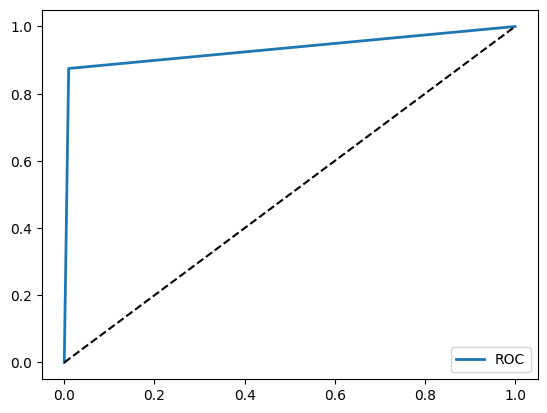

In [69]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label="ROC")
    plt.plot([0,1],[0,1],'k--')
plot_roc_curve(fpr,tpr)
plt.legend(loc="lower right")
plt.show()

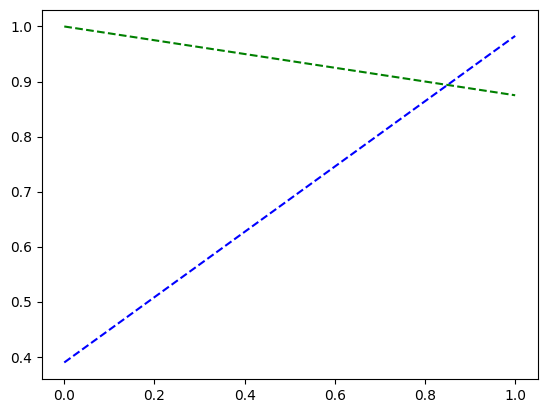

In [70]:
precisions,recalls,thresholds = precision_recall_curve(y_test,y_pred)
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

In [71]:
confusion_matrix(y_test, y_pred)

array([[4569,   45],
       [ 368, 2576]], dtype=int64)

add player names to get QB and Receiver for all plays

In [72]:
players = pd.read_csv("data/players.csv")
pff_qbs = pff[pff["pff_role"]=="Pass"]
pff_names = pff_qbs.merge(players[["nflId","displayName"]], on = "nflId")
table_list3 = table_list2.merge(pff_names[["comb_id","displayName"]], on = "comb_id")
table_list4 = table_list3.merge(plays[["comb_id","PassReceiver_displayName"]], on = "comb_id")